# Sentiment Analysis

In [27]:
import string
import sys
from gc import collect
from os import chdir

import matplotlib.pyplot as plt
import nltk
# import libraries
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

sys.path.insert(0, '..')

from src import RAW_TEST_DATA, RAW_TRAIN_DATA, PROCESSED_TRAIN_DATA, PROCESSED_TEST_DATA
from src.preprocessing import DataCleaner, Lemmatizer, Tokenizer

In [2]:
# change directory to root
chdir('..')

## Data

In [3]:
# load data
train_data = pd.read_csv(RAW_TRAIN_DATA, names=['label', 'description', 'review'])
test_data = pd.read_csv(RAW_TEST_DATA, names=['label', 'description', 'review'])
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (3000000, 3)
Test data shape: (650000, 3)


In [4]:
# check for missing values in train data
train_data.isnull().sum()

label            0
description    188
review           0
dtype: int64

In [5]:
# check for missing values in test data
test_data.isnull().sum()

label           0
description    26
review          0
dtype: int64

In [6]:
# since we are not using the description column, we can drop it from all the data
train_data = train_data.drop(columns=['description'])
test_data = test_data.drop(columns=['description'])

### Explore the data

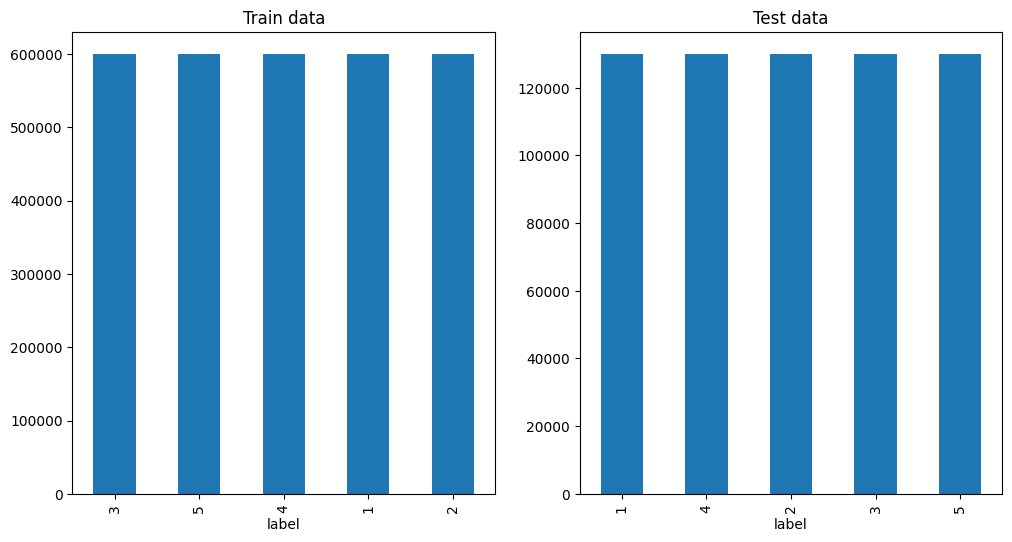

In [7]:
# let's see histogram of the labels in both train and test data
_, ax = plt.subplots(1, 2, figsize=(12, 6))
train_data['label'].value_counts().plot(kind='bar', ax=ax[0], title='Train data')
test_data['label'].value_counts().plot(kind='bar', ax=ax[1], title='Test data')
plt.show()

## Change the labels to positive and negative

According to the data description, 1-2 stars are negative and 4-5 stars are positive, 3 stars are neutral.
Since we are making a binary classification, we can change the labels to negative and positive.
Meaning we can drop the neutral labels.

In [8]:
# drop neutral labels
train_data = train_data[train_data['label'] != 3]
test_data = test_data[test_data['label'] != 3]

# change the labels to 0 for negative and 1 for positive
train_data['label'] = train_data['label'].apply(lambda x: 0 if x < 3 else 1)
test_data['label'] = test_data['label'].apply(lambda x: 0 if x < 3 else 1)

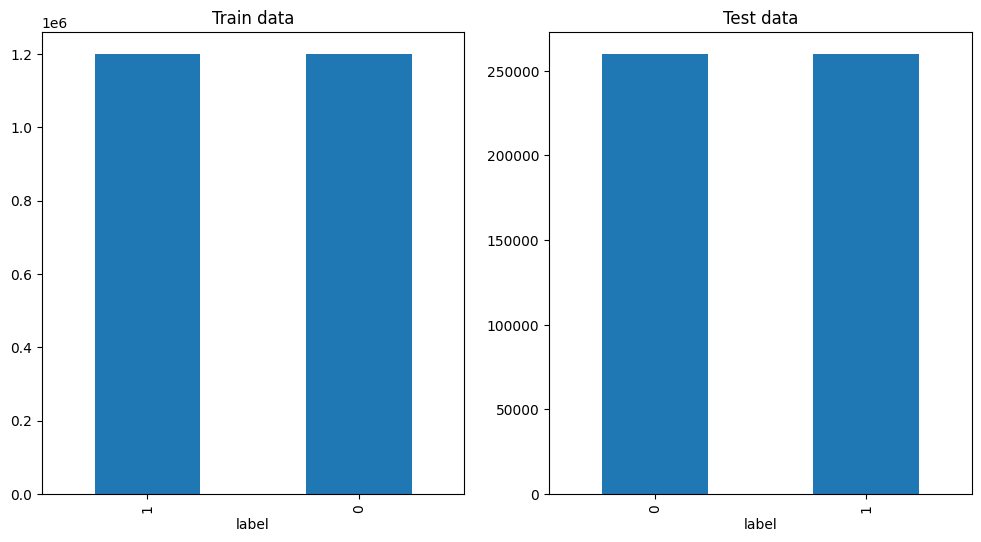

In [9]:
# confirm the changes
_, ax = plt.subplots(1, 2, figsize=(12, 6))
train_data['label'].value_counts().plot(kind='bar', ax=ax[0], title='Train data')
test_data['label'].value_counts().plot(kind='bar', ax=ax[1], title='Test data')
plt.show()

Let's see the first few rows of the data.

In [10]:
train_data.head()

,label,review
1,1,I hope a lot of people hear this cd. We need m...
2,1,I'm reading a lot of reviews saying that this ...
3,1,The music of Yasunori Misuda is without questi...
4,1,Probably the greatest soundtrack in history! U...
5,1,"There's a reason this CD is so expensive, even..."


In [11]:
test_data.head()

,label,review
0,0,"This model may be ok for sedentary types, but ..."
1,1,This is a fast read filled with unexpected hum...
2,0,I bought one of these chargers..the instructio...
3,0,I was excited to find a book ostensibly about ...
4,0,"I am a big JVC fan, but I do not like this mod..."


Now save the data to the processed folder, and use only part of the data for more efficient data analysis and models comparison.

In [12]:
# save the data
train_data.to_csv(PROCESSED_TRAIN_DATA, index=False, header=False)
test_data.to_csv(PROCESSED_TEST_DATA, index=False, header=False)

# Sample the data for further analysis

In [13]:
def sample_data(df, fraction, random_state=42):
    positive = df[df['label'] == 1]
    negative = df[df['label'] == 0]

    positive_sample = positive.sample(frac=fraction, random_state=random_state)
    negative_sample = negative.sample(frac=fraction, random_state=random_state)

    sampled_data = pd.concat([positive_sample, negative_sample])
    sample_data = sampled_data.sample(frac=1, random_state=random_state)  # shuffle the data

    return sample_data

In [14]:
# sample the data, use 10% of the data for space efficiency
train_sampled = sample_data(train_data, 0.1)
test_sampled = sample_data(test_data, 0.1)

In [15]:
# free up memory
del train_data
del test_data
collect()

9

# Closer look at the sampled data

In [16]:
all_samples = pd.concat([train_sampled, test_sampled])

### Words that are most common in the reviews types.

In [17]:
def draw_wordcloud(data, title, ax=None):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(text)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)


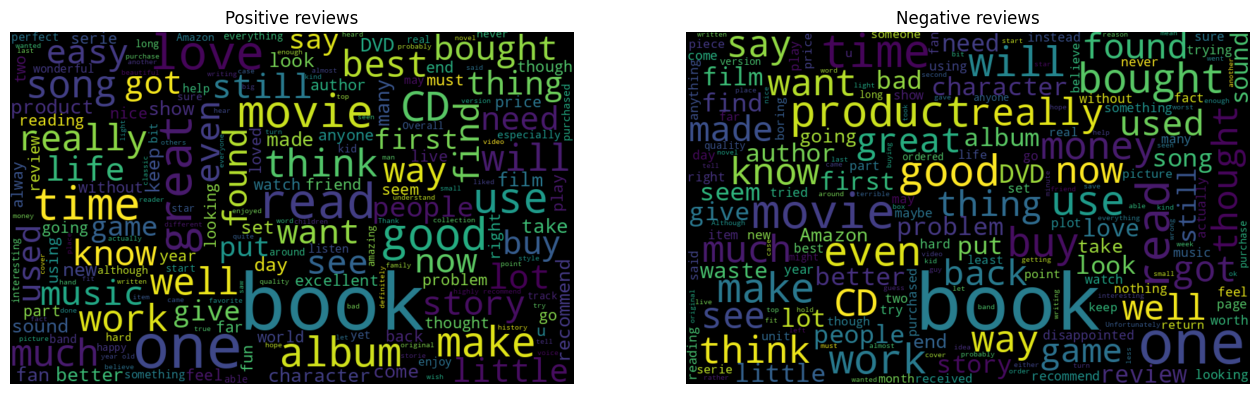

In [18]:
# draw word clouds for positive and negative reviews
positive_reviews = all_samples[all_samples['label'] == 1]['review']
negative_reviews = all_samples[all_samples['label'] == 0]['review']

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
draw_wordcloud(positive_reviews, 'Positive reviews', ax=ax[0])
draw_wordcloud(negative_reviews, 'Negative reviews', ax=ax[1])
plt.show()


### Most common words in the reviews

In [19]:
# download the necessary nltk data
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/krystian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# extract words from samples
words = all_samples['review'].apply(lambda text: word_tokenize(text.lower())).explode()
words_count = words.value_counts().reset_index()
words_count.columns = ['word', 'count']
words_count.head()

,word,count
0,.,1173999
1,the,1134752
2,",",819895
3,i,643502
4,and,609519


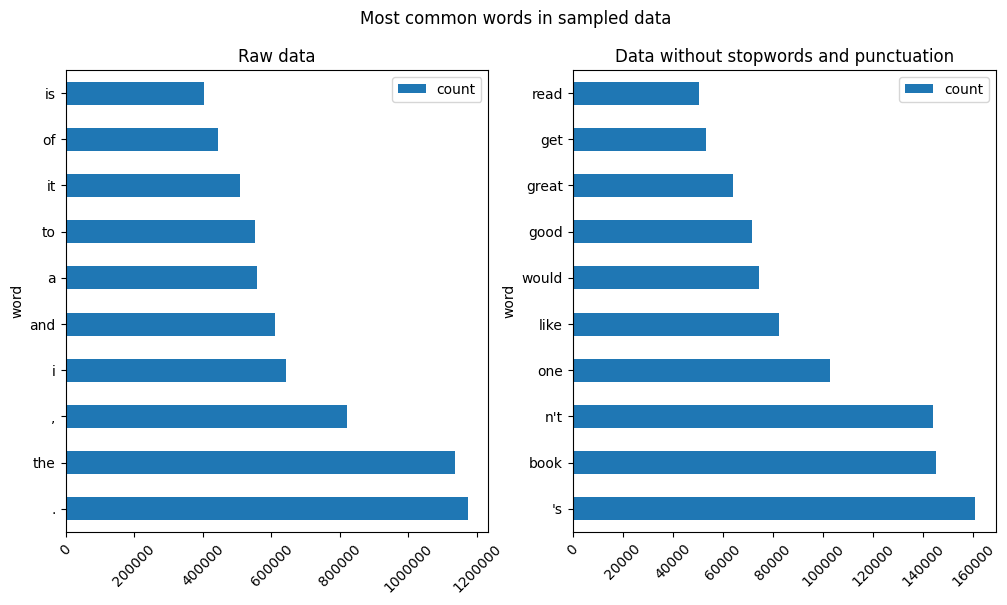

In [21]:
# remove stopwords and punctuation
stopwords_and_punctuation = list(stopwords) + list(string.punctuation) + ['``', "''"]
words_count_processed = words_count[~words_count['word'].isin(stopwords_and_punctuation)]

# plot the most common words for processed data and unprocessed data
_, ax = plt.subplots(1, 2, figsize=(12, 6))
words_count.head(10).plot(kind='barh', x='word', y='count', ax=ax[0])
ax[0].set_title('Raw data')
ax[0].tick_params(axis="x", rotation=45)
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

words_count_processed.head(10).plot(kind='barh', x='word', y='count', ax=ax[1])
ax[1].set_title('Data without stopwords and punctuation')
ax[1].tick_params(axis="x", rotation=45)
ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

plt.suptitle('Most common words in sampled data')
plt.show()

As we can see, the most common words are stopwords and punctuation. We have to remove them, because they don't provide any useful information for sentiment analysis.

### Check the correlation between the review length and the label

In [22]:
review_length = all_samples['review'].apply(len)
data = pd.DataFrame({'review_length': review_length, 'label': all_samples['label']})

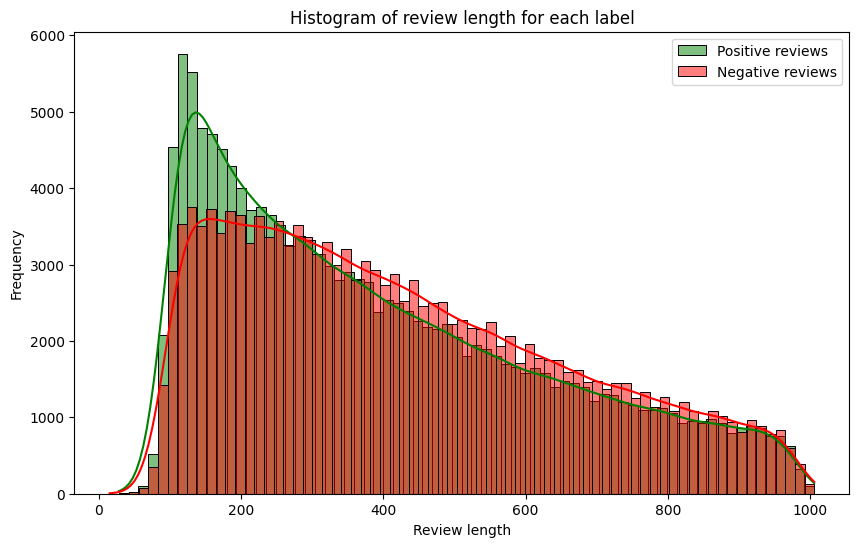

In [28]:
# plot the histogram of review length for each label
plt.figure(figsize=(10, 6))
sns.histplot(data[data['label'] == 1]['review_length'], color='green', kde=True, label='Positive reviews')
sns.histplot(data[data['label'] == 0]['review_length'], color='red', kde=True, label='Negative reviews')
plt.title('Histogram of review length for each label')
plt.xlabel('Review length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [29]:
# calculate the correlation between the review length and the label
correlation = data['review_length'].corr(data['label'])
print(f'Correlation between review length and label: {correlation:.4f}')

Correlation between review length and label: -0.0675


The correlation between the review length and the label is very low, which means that the review length is not a good predictor for the label.

# Pipeline

The pipeline will be used to preprocess the data, and train the model. 

The pipeline will consist of the following steps:
1. Clean the data - convert all words to lowercase, remove stopwords, punctuation, URLs, Handles, emojis and extra spaces from the given text.
2. Tokenization - convert text to list of words.
3. Lemmatization - convert words to their base form (lemmas).


In [30]:
# In jupyter notebook, we will use only part of the data for more efficient data analysis and models comparison.
# Split the data into train and test sets
X_train = train_sampled['review']
y_train = train_sampled['label']
X_test = test_sampled['review']
y_test = test_sampled['label']

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

# create a pipeline
preprocessing_pipeline = Pipeline([
    ('cleaner', DataCleaner()),
    ('tokenizer', Tokenizer()),
    ('lemmatizer', Lemmatizer()),
])